In [1]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy import stats
import shap
import seaborn as sns

def calculate_correlations(shap_values, features_df, feature_names, num_classes):
    correlation_df = pd.DataFrame()

    for feature in feature_names:
        correlation_dict = {'feature': feature}

        for i in range(num_classes):
            shap_values_i = shap_values[i][:, features_df.columns.get_loc(feature)]
            feature_values_i = features_df[feature].values

            correlation_coefficient_i = np.corrcoef(shap_values_i, feature_values_i)[0, 1]
            correlation_dict[f'correlation_{i}'] = correlation_coefficient_i

        correlation_df = correlation_df.append(correlation_dict, ignore_index=True)

    return correlation_df

def XGBoost(X, y):
    # データを訓練用とテスト用に分割
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # 訓練データをさらに訓練用と検証用に分割
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

    # モデルのパラメータを設定(CPU)
    params = {
        'objective': 'multi:softmax',
        'eval_metric': 'mlogloss',
        'num_class' : 2,
        'eta': 0.1,
        'max_depth': 4,
        'seed': 0,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor'
    }
    
    # データをpandas.DataFrame形式で保存
    X_train_df = pd.DataFrame(X_train, columns=column_names)
    y_train_df = pd.DataFrame(y_train, columns=column_names)

    # 訓練データと検証データをXGBoostのDMatrix形式に変換
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # 訓練データと検証データのセットをリストに格納
    evals = [(dtrain, 'train'), (dval, 'eval')]

    # モデルを訓練
    bst = xgb.train(params, dtrain, num_boost_round=10000, evals=evals, early_stopping_rounds=100)

    # テストデータをDMatrix形式に変換
    dtest = xgb.DMatrix(X_test)

    # 訓練データで予測
    y_train_pred = bst.predict(dtrain)

    # テストデータで予測
    y_pred = bst.predict(dtest)

    # 評価
    train_accuracy = accuracy_score(y_train, y_train_pred.round())
    print(f"Training Accuracy: {train_accuracy*100:.2f}%")

    # 評価
    test_accuracy = accuracy_score(y_test, y_pred.round())
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")
        
    return X_train_df, y_train_df, bst

def normalize_per_state(df, start, end):
    scaler = StandardScaler()
    df.iloc[start:end, :] = scaler.fit_transform(df.iloc[start:end, :])
    return df

In [10]:
# 1秒ごとのデータに分割
n_samples_per_second = 256  # 256Hzのサンプリングレート
total_seconds = 10  # 全体の秒数

# データの読み込み
df = pd.read_csv('DP_all.csv')

"""
# チャンネルごとに正規化
scaler = StandardScaler()
for column in df.columns[:-1]:  # 'State'列を除くすべての列
    df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1))
"""

"\n# チャンネルごとに正規化\nscaler = StandardScaler()\nfor column in df.columns[:-1]:  # 'State'列を除くすべての列\n    df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1))\n"

In [11]:
# Hzごと
# 特徴量と目標変数を抽出する
X = df.drop('Marker', axis=1)  # 'State'以外の列すべてを特徴量とします
y = df['Marker']  # 'State'を目標変数とします

# 列名のリストを定義
column_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
#XGBoost
X_train_df, y_train_df, bst = XGBoost(X, y)

[0]	train-mlogloss:0.63142	eval-mlogloss:0.63887
[1]	train-mlogloss:0.58247	eval-mlogloss:0.59915
[2]	train-mlogloss:0.53633	eval-mlogloss:0.56356
[3]	train-mlogloss:0.50091	eval-mlogloss:0.53167
[4]	train-mlogloss:0.46519	eval-mlogloss:0.50436
[5]	train-mlogloss:0.43639	eval-mlogloss:0.48301
[6]	train-mlogloss:0.41095	eval-mlogloss:0.46506
[7]	train-mlogloss:0.38178	eval-mlogloss:0.44501
[8]	train-mlogloss:0.36038	eval-mlogloss:0.42756
[9]	train-mlogloss:0.33725	eval-mlogloss:0.41258
[10]	train-mlogloss:0.32074	eval-mlogloss:0.39858
[11]	train-mlogloss:0.30438	eval-mlogloss:0.38752
[12]	train-mlogloss:0.28705	eval-mlogloss:0.37609
[13]	train-mlogloss:0.27283	eval-mlogloss:0.36534
[14]	train-mlogloss:0.26038	eval-mlogloss:0.35623
[15]	train-mlogloss:0.24257	eval-mlogloss:0.34573
[16]	train-mlogloss:0.23295	eval-mlogloss:0.33923
[17]	train-mlogloss:0.21864	eval-mlogloss:0.32922
[18]	train-mlogloss:0.20657	eval-mlogloss:0.32348
[19]	train-mlogloss:0.19978	eval-mlogloss:0.31746
[20]	train

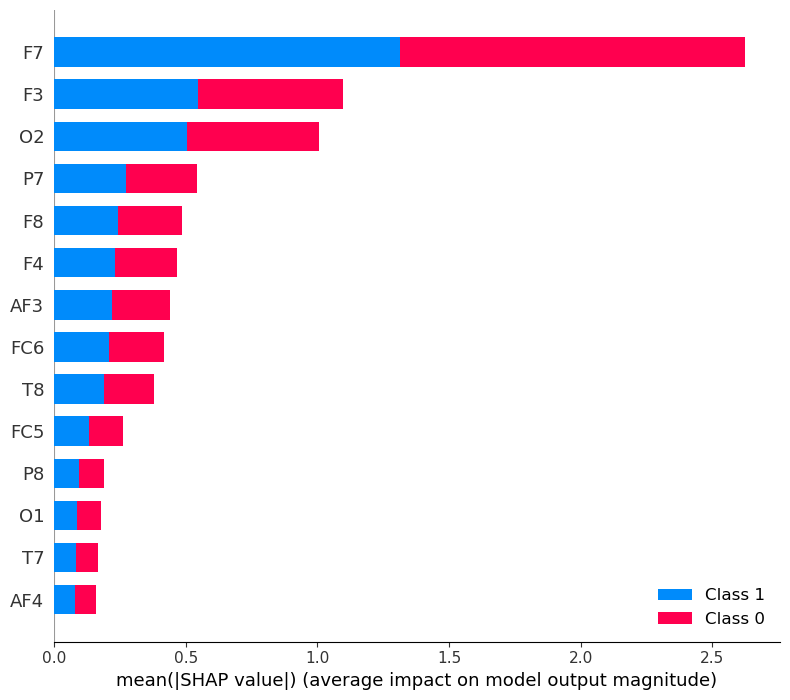

In [4]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train_df,y_train_df)

shap.summary_plot(shap_values, X_train_df)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


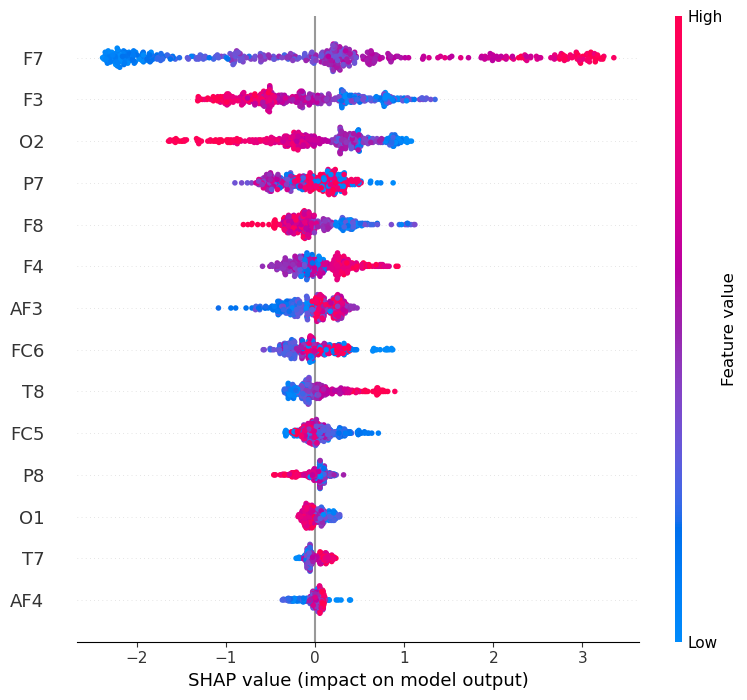

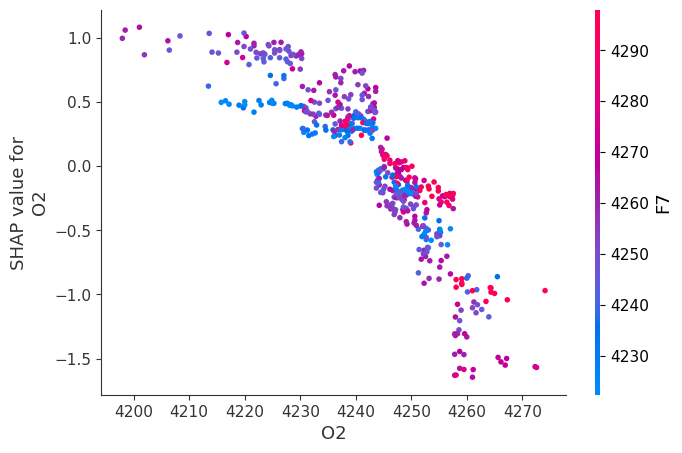

In [5]:
# SHAP値をプロット
shap.summary_plot(shap_values[0], X_train_df, max_display=X_train_df.shape[1])
#各ｃｈの電圧値とSHAP値の線形グラフ
shap.dependence_plot("O2", shap_values[0], X_train_df)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


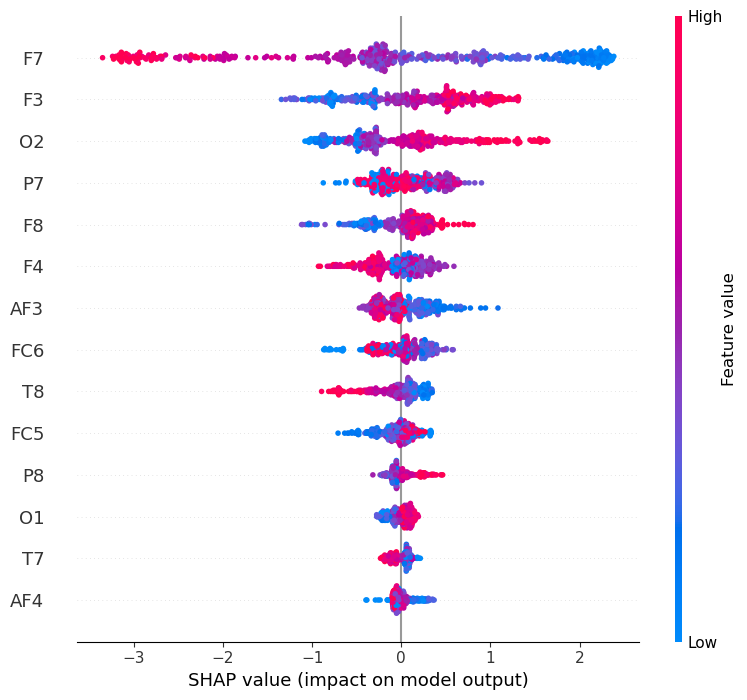

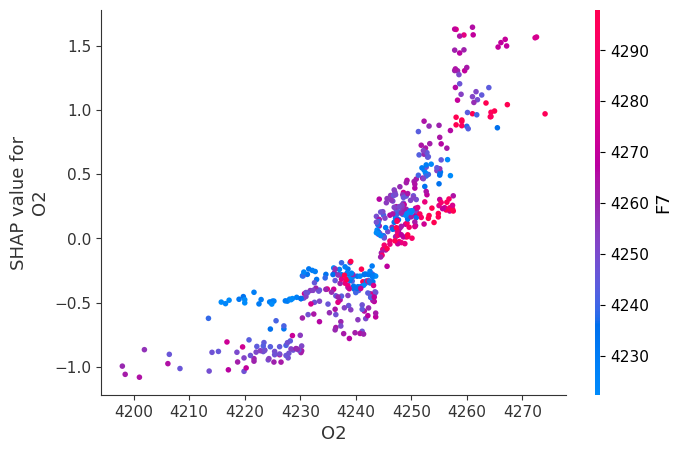

In [6]:
# SHAP値をプロット
shap.summary_plot(shap_values[1], X_train_df, max_display=X_train_df.shape[1])
#各ｃｈの電圧値とSHAP値の線形グラフ
shap.dependence_plot("O2", shap_values[1], X_train_df)

In [7]:
num_classes = 2  # クラス数を設定
correlation_df = calculate_correlations(shap_values, X_train_df, column_names, num_classes).T
correlation_df

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
feature,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
correlation_0,0.593271,0.938342,-0.850133,-0.368959,0.734139,0.104765,-0.806387,-0.876396,-0.697486,0.91898,0.063467,0.576935,-0.795737,0.503075
correlation_1,-0.593271,-0.938342,0.850133,0.368959,-0.734139,-0.104765,0.806387,0.876396,0.697486,-0.91898,-0.063467,-0.576935,0.795737,-0.503075
